In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

from IPython.display import clear_output

ФИО: Васильев Семён Михайлович

### Creating config object (argparse workaround)

In [2]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 100
config.noise_size = 50
config.print_freq = 100
config.class_num = 10

### Create dataloder

In [3]:
dataset = torchvision.datasets.MNIST(root='.', transform=torchvision.transforms.ToTensor(), download=True)
dataloader = DataLoader(dataset=dataset, batch_size=config.batch_size,
                            shuffle=True, num_workers=config.num_workers)

In [4]:
len(dataloader)

3750

In [5]:
for image, cat in dataloader:
    break

In [6]:
image.size()

torch.Size([16, 1, 28, 28])

In [7]:
for X, y in dataloader:
    X = X.view(X.size(0), -1)
    X = X.numpy()
    y = y.numpy()

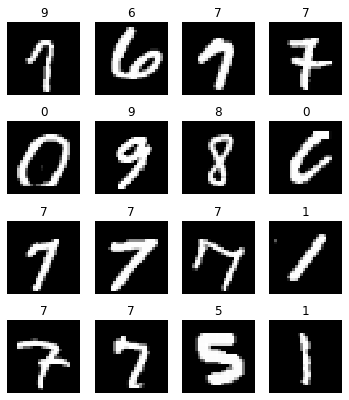

In [8]:
plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Create generator and discriminator

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [10]:
GAN_generator = Generator()
GAN_discriminator = Discriminator()

### Create optimizers and loss

In [11]:
optim_G = optim.Adam(params=GAN_generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=GAN_discriminator.parameters(), lr=0.0001)

In [12]:
criterion = nn.BCELoss()

### Create necessary variables

In [13]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

### Задание

1) Посмотрите на реализацию GAN. Постройте интерполяцию между какими-нибудь двумя сгенерированными картинками. (Опционально)Добавьте свертки в генератор и дискриминатор, как в статье про DCGAN.

2) Поменяйте ее, чтобы получился LSGAN https://arxiv.org/pdf/1611.04076v2.pdf

3) Добавьте к обучению GAN условие на метку, продемонстрируйте условную генерацию. https://arxiv.org/pdf/1411.1784.pdf

4) Напишите отчет что попробовали, какие результаты получили, как вам кажется надо обучать GAN, чтобы добиться сходимости?

В каждом пункте постройте графики функций потерь.

### GAN

In [14]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        GAN_discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = GAN_discriminator(input_data)
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = GAN_generator(noise)
        label.data.fill_(fake_label)
        output = GAN_discriminator(fake.detach())
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        GAN_generator.zero_grad()
        label.data.fill_(real_label)
        output = GAN_discriminator(fake)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
    clear_output(True)    
    print('Epoch:{} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                    ERRD_x[epoch] / N,
                                                                    ERRD_z[epoch] / N, 
                                                                    ERRG[epoch] / N))
ERRD_x /= N
ERRD_z /= N
ERRG /= N

Epoch:100 errD_x: 0.20 errD_z: 0.09 errG: 2.82


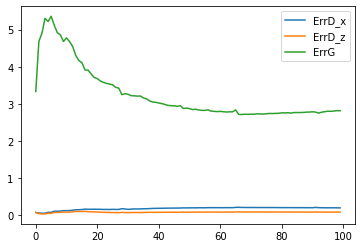

In [15]:
plt.plot(ERRD_x, label='ErrD_x')
plt.plot(ERRD_z, label='ErrD_z')
plt.plot(ERRG, label='ErrG')
plt.legend()
plt.show()

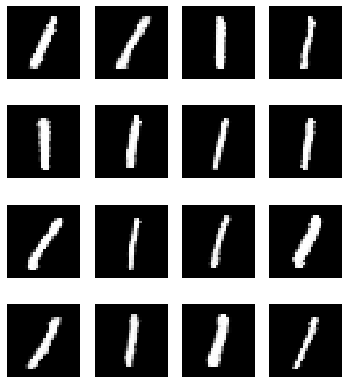

In [16]:
noise.data.normal_(0, 1)
fake = GAN_generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### Интерполяция

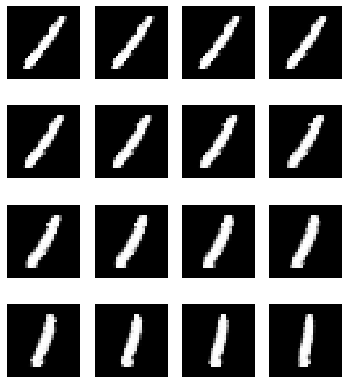

In [49]:
noise_1 = torch.FloatTensor(config.noise_size)
noise_1.data.normal_(0, 1)
noise_2 = torch.FloatTensor(config.noise_size)
noise_2.data.normal_(0, 1)
diff = (noise_2 - noise_1) / config.batch_size
arr = []
for i in range(config.batch_size):
    arr.append(GAN_generator(noise_1 + diff * i))

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(arr[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

## LSGAN

In [18]:
LSGAN_generator = Generator()
LSGAN_discriminator = Discriminator()

In [19]:
optim_G = optim.Adam(params=LSGAN_generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=LSGAN_discriminator.parameters(), lr=0.0001)

In [20]:
criterion = nn.MSELoss()

In [21]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage
        #######
        LSGAN_discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = LSGAN_discriminator(input_data)
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = LSGAN_generator(noise)
        label.data.fill_(fake_label)
        output = LSGAN_discriminator(fake.detach())
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage
        #######
        LSGAN_generator.zero_grad()
        label.data.fill_(real_label)
        output = LSGAN_discriminator(fake)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
    clear_output(True)    
    print('Epoch:{} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                    ERRD_x[epoch] / N,
                                                                    ERRD_z[epoch] / N, 
                                                                    ERRG[epoch] / N))
ERRD_x /= N
ERRD_z /= N
ERRG /= N

Epoch:100 errD_x: 0.07 errD_z: 0.01 errG: 0.85


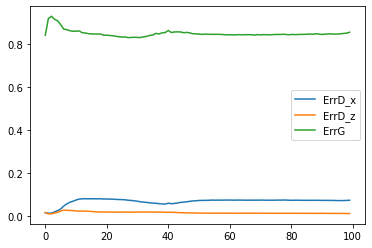

In [22]:
plt.plot(ERRD_x, label='ErrD_x')
plt.plot(ERRD_z, label='ErrD_z')
plt.plot(ERRG, label='ErrG')
plt.legend()
plt.show()

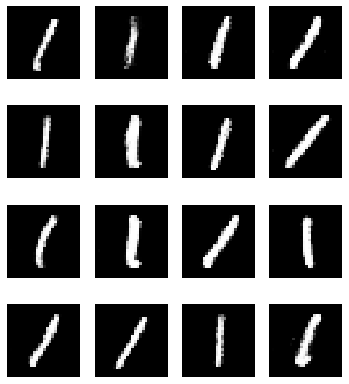

In [23]:
noise.data.normal_(0, 1)
fake = LSGAN_generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

In [24]:
class CondGenerator(nn.Module):
    def __init__(self):
        super(CondGenerator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size + config.class_num, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class CondDiscriminator(nn.Module):
    def __init__(self):
        super(CondDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28 + config.class_num, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [25]:
cond_generator = CondGenerator()
cond_discriminator = CondDiscriminator()

In [26]:
optim_G = optim.Adam(params=cond_generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=cond_discriminator.parameters(), lr=0.0001)

In [27]:
criterion = nn.BCELoss()

In [28]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage
        #######
        cond_discriminator.zero_grad()
        
        cond = F.one_hot(cat, num_classes=10).type(torch.float)
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        input_data = torch.cat((input_data, cond), dim=1)
        output = cond_discriminator(input_data)
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        input_data = torch.cat((noise, cond), dim=1)
        fake = cond_generator(input_data)
        label.data.fill_(fake_label)
        fake = torch.cat((fake, cond), dim=1)
        output = cond_discriminator(fake.detach())
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage
        #######
        cond_generator.zero_grad()
        label.data.fill_(real_label)
        output = cond_discriminator(fake)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
    clear_output(True)    
    print('Epoch:{} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                    ERRD_x[epoch] / N,
                                                                    ERRD_z[epoch] / N, 
                                                                    ERRG[epoch] / N))
ERRD_x /= N
ERRD_z /= N
ERRG /= N

Epoch:100 errD_x: 0.24 errD_z: 0.19 errG: 3.45


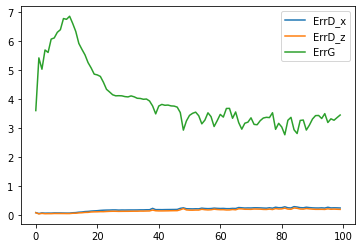

In [29]:
plt.plot(ERRD_x, label='ErrD_x')
plt.plot(ERRD_z, label='ErrD_z')
plt.plot(ERRG, label='ErrG')
plt.legend()
plt.show()

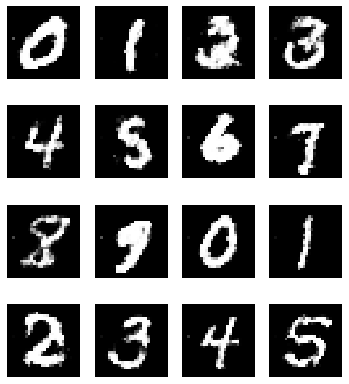

In [30]:
noise.data.normal_(0, 1)
cond = torch.Tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.] for i in range(16)]).type(torch.float)
for i in range(16):
    cond[i][i % 10] = 1
input_data = torch.cat((noise, cond), dim=1)
fake = cond_generator(input_data)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

Обычный GAN научился хорошо генерировать одну цифру. С условной получилось добиться генерации разных.